In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 314
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  HEAWIHTQ_17_09_05
NN-MODEL FILENAME:  ./models/HEAWIHTQ_17_09_05_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [14]:
# SET GRANULARITY
HI_GRAIN = 30
LO_GRAIN = 30
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  30
LO_GRAIN =  30


In [15]:
def mp_node_run(node_id, boundary, iteration):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = boundary
    ###############################################
    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN, LENGTH_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    
#     my_dqn = D3QN()
    my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    my_dqn.eval_net.eval()
#     my_QFILE   = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#     my_Q_TABLE = np.load(my_QFILE)
    my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
    if iteration < 3:
        my_EPSILON   = (iteration+1) * 0.2 + np.random.uniform(-0.1,0.1)
    else:
        my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

#     LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX, LENGTH_ABS_MAX)
#     LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN, LENGTH_ABS_MAX)
    ###############################################
    
    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
my_dqn = D3QN()
dqn = D3QN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# INITIALIZE QFILES FOR EACH NODE
#############################################################################################################################################
# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]

#  # SET STATE VALUE BORDERS
# ###############################################
# [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#  C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = init_node_boundary
# ###############################################

# # CREATE STATE COMBINATIONS
# ###############################################

# init_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
#                                     [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
#                                     [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
# ###############################################

# # GET Q-VALUES 
# start = timeit.default_timer()
# % memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
# stop = timeit.default_timer()
# print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# # SAVE QFILE
# for node_id in range(NO_OF_NODES):
#     node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#     np.save(node_QFILE, init_q_table)
# #############################################################################################################################################

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES



ITERATION # 0
MEAN TABULAR EPSILON =  0.2
TABULAR LR      =  0.1
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 17147 EXPERIENCES:0:00:17.861581


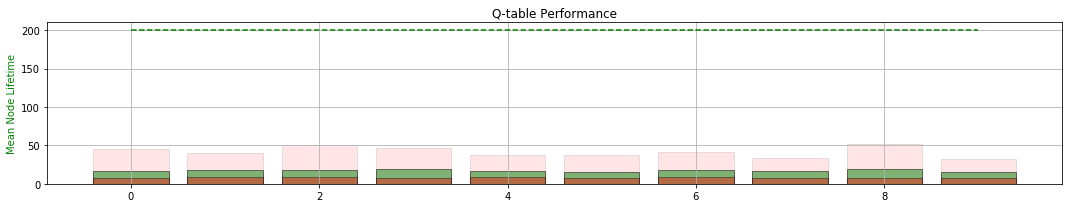

GOOD MEMORY COUNTER:  16147
BAD MEMORY COUNTER:  1000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  164.735
Validating... MEAN TIME:  170.115
Validating... MEAN TIME:  149.755
Validating... MEAN TIME:  154.88
Validating... MEAN TIME:  143.465
TRAINING TIME:0:00:40.304891


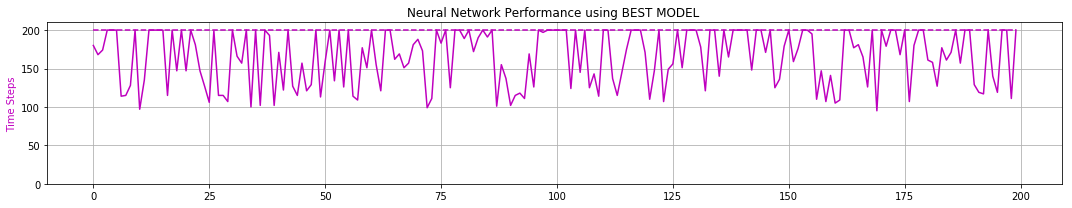

0 -max- [ 0.166  1.732  0.209  2.895  0.474]
0 -min- [-0.209 -1.970 -0.209 -2.727  0.425]

1 -max- [ 0.213  1.724  0.209  2.666  0.525]
1 -min- [-0.295 -1.737 -0.209 -2.672  0.475]

2 -max- [ 0.188  1.598  0.209  2.687  0.574]
2 -min- [-0.210 -1.794 -0.209 -2.470  0.525]

3 -max- [ 0.209  1.576  0.209  2.739  0.625]
3 -min- [-0.513 -2.330 -0.208 -2.435  0.578]

4 -max- [ 0.261  1.941  0.209  2.535  0.675]
4 -min- [-0.196 -1.777 -0.207 -2.721  0.625]

5 -max- [ 0.200  1.583  0.209  2.762  0.725]
5 -min- [-0.337 -1.758 -0.208 -2.439  0.676]

6 -max- [ 0.222  1.757  0.209  2.783  0.775]
6 -min- [-0.221 -1.982 -0.209 -2.589  0.726]

7 -max- [ 0.192  1.514  0.208  2.754  0.825]
7 -min- [-0.207 -1.757 -0.209 -2.374  0.775]

8 -max- [ 0.294  1.776  0.209  2.451  0.874]
8 -min- [-0.230 -1.595 -0.209 -2.731  0.826]

9 -max- [ 0.171  1.768  0.209  2.901  0.925]
9 -min- [-0.216 -1.973 -0.209 -2.674  0.876]



ITERATION # 1
MEAN TABULAR EPSILON =  0.4
TABULAR LR      =  0.1
SMALLEST TIMESTEP in IT

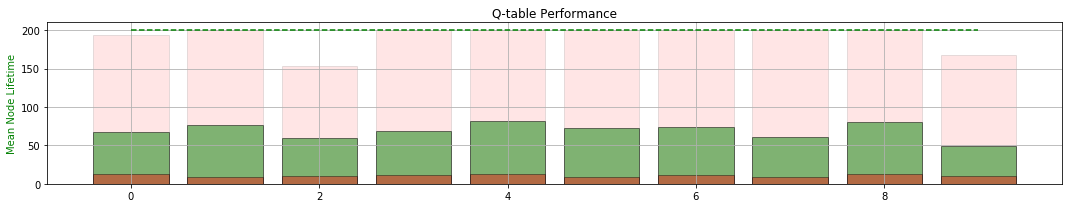

GOOD MEMORY COUNTER:  84052
BAD MEMORY COUNTER:  1992
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  183.485
Validating... MEAN TIME:  174.6
Validating... MEAN TIME:  185.625
Validating... MEAN TIME:  199.675
Validating... MEAN TIME:  199.815
TRAINING TIME:0:00:46.838731


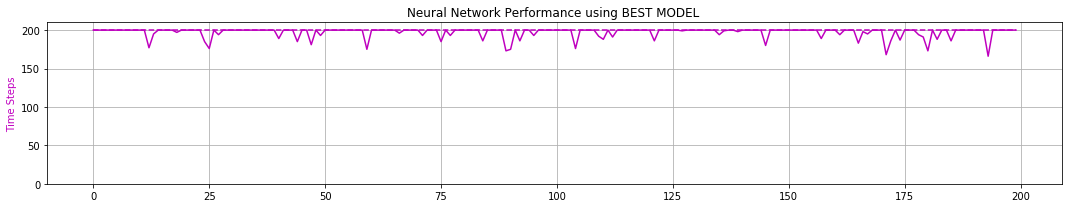

0 -max- [ 0.947  1.772  0.209  2.457  0.475]
0 -min- [-2.205 -3.187 -0.209 -2.418  0.425]

1 -max- [ 1.093  1.451  0.208  2.804  0.525]
1 -min- [-2.397 -2.803 -0.209 -2.022  0.475]

2 -max- [ 0.936  1.919  0.209  2.479  0.575]
2 -min- [-1.666 -2.204 -0.209 -2.408  0.525]

3 -max- [ 1.273  1.701  0.209  2.068  0.625]
3 -min- [-2.104 -2.243 -0.209 -2.286  0.576]

4 -max- [ 0.997  1.751  0.208  2.057  0.675]
4 -min- [-2.081 -2.639 -0.209 -2.097  0.626]

5 -max- [ 1.162  1.725  0.209  1.926  0.725]
5 -min- [-1.617 -2.239 -0.209 -2.337  0.675]

6 -max- [ 1.086  1.691  0.209  2.212  0.775]
6 -min- [-2.086 -2.746 -0.209 -2.095  0.725]

7 -max- [ 1.161  2.049  0.208  2.687  0.823]
7 -min- [-1.861 -2.634 -0.209 -2.450  0.775]

8 -max- [ 1.047  1.631  0.208  1.786  0.875]
8 -min- [-1.383 -2.274 -0.209 -2.561  0.825]

9 -max- [ 0.822  2.275  0.209  2.306  0.925]
9 -min- [-2.384 -2.823 -0.209 -2.326  0.875]



ITERATION # 2
MEAN TABULAR EPSILON =  0.6000000000000001
TABULAR LR      =  0.1
SMALLEST

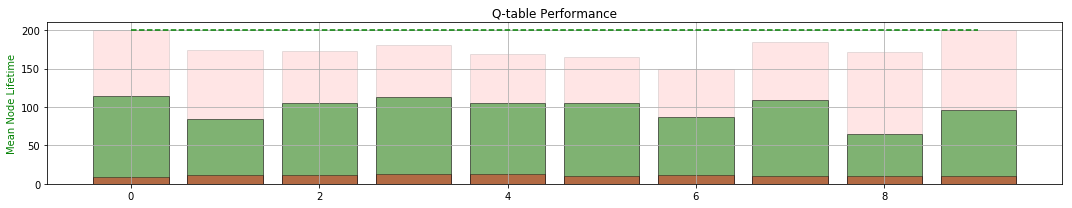

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  2990
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  173.255
Validating... MEAN TIME:  163.82
Validating... MEAN TIME:  174.515
Validating... MEAN TIME:  153.235
Validating... MEAN TIME:  160.405
TRAINING TIME:0:00:42.647829


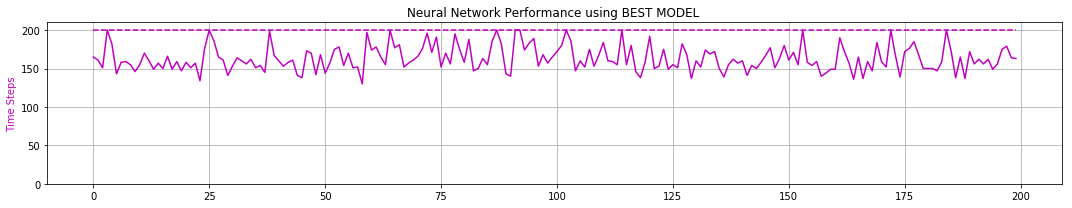

0 -max- [ 0.188  1.357  0.191  1.437  0.475]
0 -min- [-2.399 -3.133 -0.209 -2.308  0.426]

1 -max- [ 1.569  1.667  0.207  2.335  0.524]
1 -min- [-2.382 -3.574 -0.209 -2.137  0.477]

2 -max- [ 0.264  1.199  0.193  1.862  0.575]
2 -min- [-2.399 -2.982 -0.209 -1.852  0.525]

3 -max- [ 0.178  1.151  0.130  1.391  0.625]
3 -min- [-2.399 -2.980 -0.209 -1.725  0.576]

4 -max- [ 1.179  1.353  0.201  1.529  0.674]
4 -min- [-2.400 -2.919 -0.209 -1.911  0.626]

5 -max- [ 0.176  1.318  0.114  1.590  0.725]
5 -min- [-2.397 -2.945 -0.209 -2.418  0.676]

6 -max- [ 0.182  1.221  0.208  2.413  0.775]
6 -min- [-2.399 -3.274 -0.209 -1.819  0.725]

7 -max- [ 1.033  1.486  0.206  1.471  0.824]
7 -min- [-2.397 -2.987 -0.209 -1.797  0.776]

8 -max- [ 0.242  1.668  0.206  1.597  0.875]
8 -min- [-2.392 -2.873 -0.209 -2.218  0.825]

9 -max- [ 0.419  1.133  0.207  1.668  0.925]
9 -min- [-2.399 -2.904 -0.209 -1.642  0.875]



ITERATION # 3
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

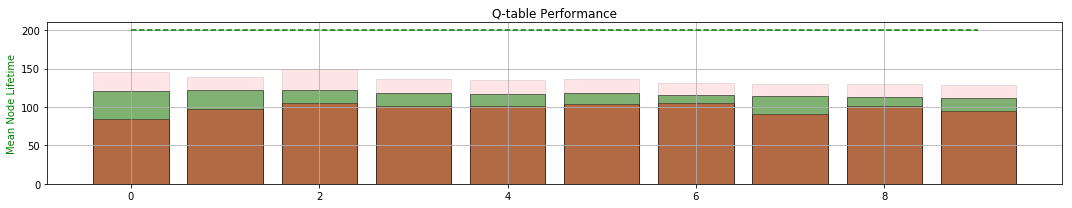

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  3990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  116.775
Validating... MEAN TIME:  130.93
Validating... MEAN TIME:  124.185
Validating... MEAN TIME:  128.95
Validating... MEAN TIME:  123.115
TRAINING TIME:0:00:34.560081


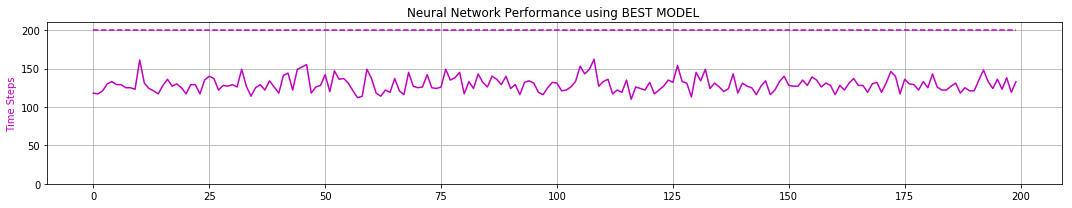

0 -max- [ 0.144  0.822  0.050  1.032  0.474]
0 -min- [-2.399 -2.960 -0.209 -1.208  0.426]

1 -max- [ 0.119  0.637  0.049  0.850  0.523]
1 -min- [-2.399 -2.948 -0.207 -0.935  0.476]

2 -max- [ 0.138  0.824  0.050  0.788  0.575]
2 -min- [-2.400 -2.945 -0.209 -1.226  0.526]

3 -max- [ 0.134  0.825  0.051  0.864  0.625]
3 -min- [-2.400 -2.977 -0.207 -1.190  0.575]

4 -max- [ 0.128  0.808  0.050  0.848  0.675]
4 -min- [-2.400 -2.977 -0.209 -1.225  0.627]

5 -max- [ 0.145  0.826  0.050  0.770  0.724]
5 -min- [-2.400 -2.959 -0.205 -1.224  0.675]

6 -max- [ 0.123  0.828  0.049  0.864  0.774]
6 -min- [-2.399 -2.977 -0.207 -1.183  0.728]

7 -max- [ 0.137  0.822  0.050  0.845  0.825]
7 -min- [-2.400 -2.953 -0.207 -1.186  0.775]

8 -max- [ 0.138  0.828  0.049  0.839  0.875]
8 -min- [-2.399 -2.977 -0.207 -1.242  0.826]

9 -max- [ 0.158  1.007  0.049  0.869  0.925]
9 -min- [-2.400 -2.974 -0.209 -1.463  0.875]



ITERATION # 4
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

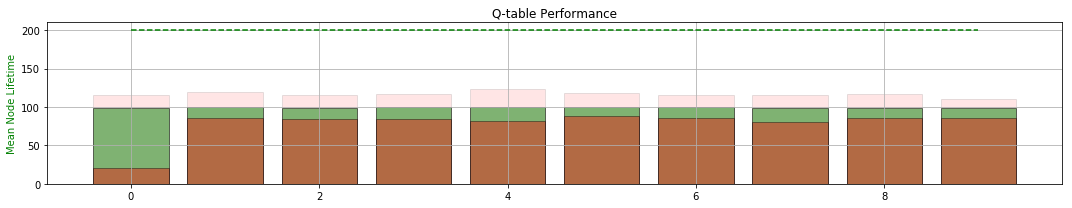

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  4990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  110.335
Validating... MEAN TIME:  115.16
Validating... MEAN TIME:  111.81
Validating... MEAN TIME:  113.4
Validating... MEAN TIME:  112.25
TRAINING TIME:0:00:31.441027


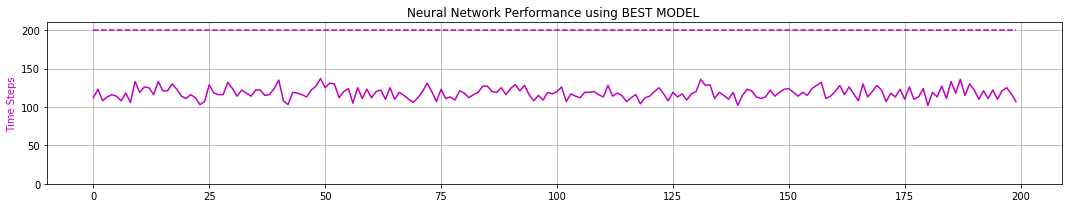

0 -max- [ 0.145  0.774  0.056  0.857  0.475]
0 -min- [-2.316 -2.774 -0.209 -1.199  0.425]

1 -max- [ 0.155  0.776  0.050  0.835  0.525]
1 -min- [-2.362 -2.776 -0.209 -1.190  0.476]

2 -max- [ 0.147  0.826  0.051  0.819  0.575]
2 -min- [-2.379 -2.777 -0.209 -1.210  0.525]

3 -max- [ 0.148  0.823  0.050  0.864  0.625]
3 -min- [-2.398 -2.963 -0.209 -1.165  0.575]

4 -max- [ 0.167  0.799  0.057  0.809  0.675]
4 -min- [-2.398 -3.072 -0.209 -1.225  0.625]

5 -max- [ 0.143  0.828  0.049  0.831  0.725]
5 -min- [-2.398 -3.108 -0.209 -1.146  0.675]

6 -max- [ 0.155  0.822  0.050  0.950  0.774]
6 -min- [-2.397 -3.119 -0.209 -1.212  0.726]

7 -max- [ 0.152  0.825  0.049  0.838  0.825]
7 -min- [-2.400 -3.078 -0.209 -1.185  0.776]

8 -max- [ 0.167  0.827  0.049  0.939  0.875]
8 -min- [-2.399 -3.121 -0.209 -1.180  0.825]

9 -max- [ 0.157  0.985  0.050  0.796  0.924]
9 -min- [-2.400 -3.122 -0.209 -1.466  0.875]



ITERATION # 5
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

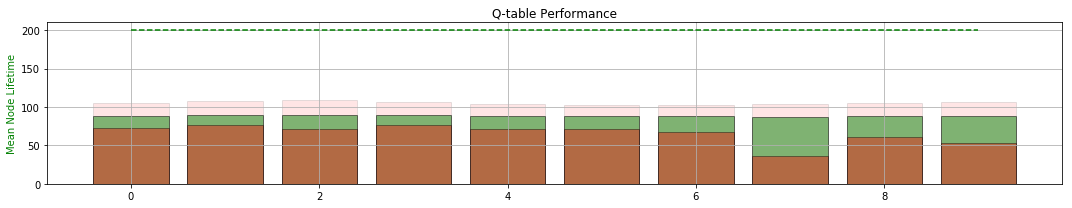

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  105.84
Validating... MEAN TIME:  111.78
Validating... MEAN TIME:  113.575
Validating... MEAN TIME:  104.29
Validating... MEAN TIME:  111.385
TRAINING TIME:0:00:30.822034


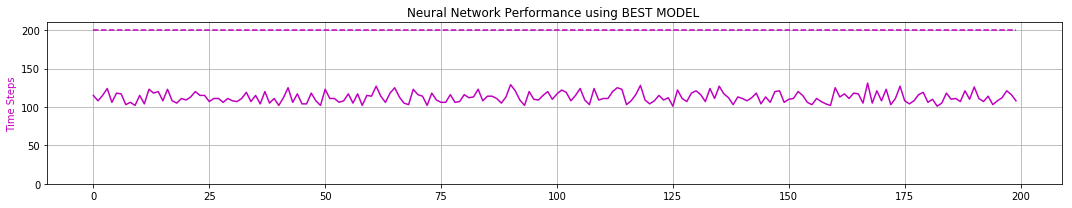

0 -max- [ 0.145  0.632  0.050  0.690  0.475]
0 -min- [-1.540 -2.406 -0.209 -0.907  0.426]

1 -max- [ 0.138  0.632  0.051  0.682  0.525]
1 -min- [-1.646 -2.539 -0.209 -0.910  0.475]

2 -max- [ 0.137  0.816  0.050  0.645  0.574]
2 -min- [-1.658 -2.575 -0.209 -1.118  0.526]

3 -max- [ 0.153  0.634  0.050  0.662  0.625]
3 -min- [-1.657 -2.553 -0.209 -0.895  0.577]

4 -max- [ 0.135  0.633  0.049  0.626  0.675]
4 -min- [-1.648 -2.429 -0.209 -0.941  0.625]

5 -max- [ 0.132  0.632  0.050  0.695  0.725]
5 -min- [-1.726 -2.519 -0.209 -0.998  0.676]

6 -max- [ 0.142  0.633  0.049  0.650  0.775]
6 -min- [-1.922 -2.714 -0.209 -0.904  0.725]

7 -max- [ 0.157  0.632  0.049  0.670  0.824]
7 -min- [-1.936 -2.764 -0.209 -0.911  0.775]

8 -max- [ 0.139  0.816  0.050  0.651  0.875]
8 -min- [-2.166 -2.940 -0.209 -1.176  0.825]

9 -max- [ 0.151  0.828  0.050  0.659  0.925]
9 -min- [-2.119 -2.916 -0.209 -1.133  0.875]



ITERATION # 6
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

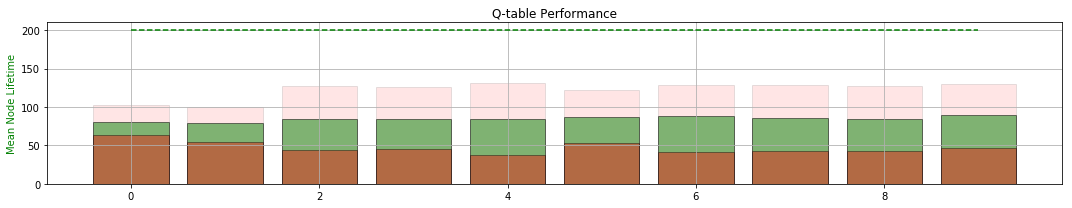

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  115.425
Validating... MEAN TIME:  114.765
Validating... MEAN TIME:  110.24
Validating... MEAN TIME:  114.645
Validating... MEAN TIME:  106.725
TRAINING TIME:0:00:32.386083


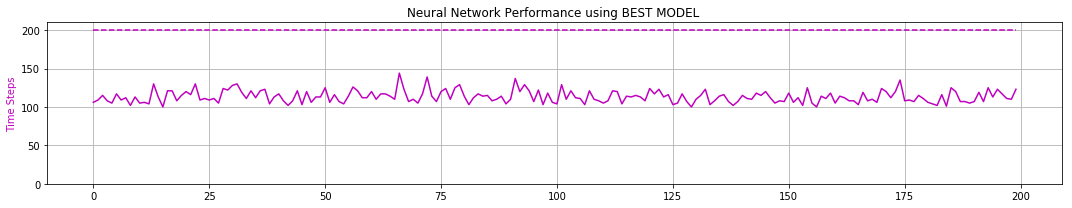

0 -max- [ 0.137  0.821  0.051  0.627  0.475]
0 -min- [-2.378 -3.106 -0.209 -1.115  0.426]

1 -max- [ 0.140  0.621  0.050  0.593  0.525]
1 -min- [-1.930 -2.789 -0.209 -0.877  0.475]

2 -max- [ 0.163  0.630  0.050  0.702  0.575]
2 -min- [-2.400 -3.337 -0.209 -0.887  0.525]

3 -max- [ 0.132  0.633  0.049  0.616  0.625]
3 -min- [-2.398 -3.338 -0.209 -0.895  0.575]

4 -max- [ 0.175  0.607  0.050  0.647  0.675]
4 -min- [-2.396 -3.329 -0.209 -0.884  0.627]

5 -max- [ 0.167  0.579  0.049  0.611  0.724]
5 -min- [-2.400 -3.331 -0.209 -0.922  0.675]

6 -max- [ 0.180  0.626  0.049  0.662  0.775]
6 -min- [-2.398 -3.337 -0.209 -0.876  0.725]

7 -max- [ 0.173  0.555  0.050  0.647  0.825]
7 -min- [-2.395 -3.339 -0.209 -0.881  0.775]

8 -max- [ 0.164  0.436  0.050  0.663  0.875]
8 -min- [-2.398 -3.337 -0.209 -1.117  0.825]

9 -max- [ 0.166  0.566  0.050  0.603  0.925]
9 -min- [-2.393 -3.340 -0.209 -0.927  0.875]



ITERATION # 7
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

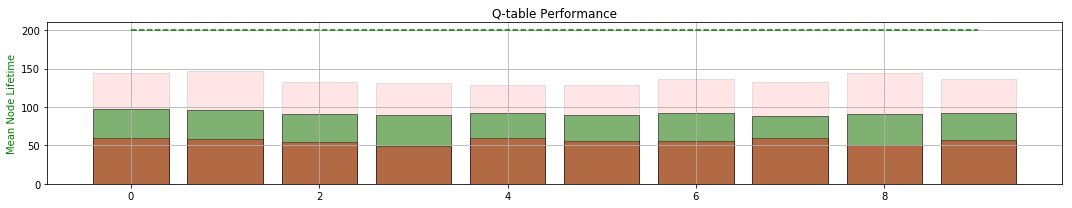

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  7990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  109.75
Validating... MEAN TIME:  116.76
Validating... MEAN TIME:  119.195
Validating... MEAN TIME:  113.41
Validating... MEAN TIME:  125.38
TRAINING TIME:0:00:32.920809


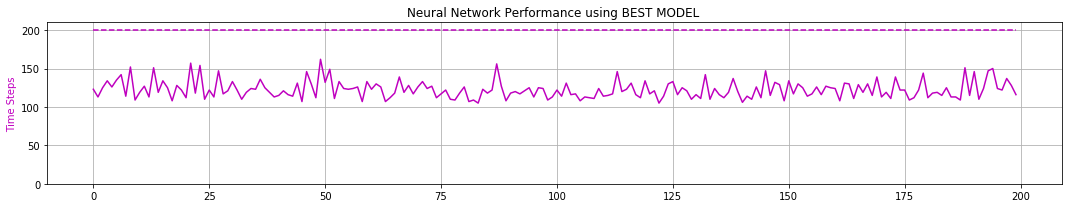

0 -max- [ 0.161  0.435  0.050  0.840  0.474]
0 -min- [-2.400 -3.493 -0.209 -0.844  0.426]

1 -max- [ 0.192  0.547  0.050  0.668  0.525]
1 -min- [-2.400 -3.484 -0.209 -0.893  0.475]

2 -max- [ 0.160  0.556  0.049  0.660  0.575]
2 -min- [-2.398 -3.499 -0.209 -0.873  0.525]

3 -max- [ 0.172  0.604  0.050  0.844  0.625]
3 -min- [-2.397 -3.521 -0.209 -0.896  0.575]

4 -max- [ 0.167  0.604  0.049  0.654  0.675]
4 -min- [-2.398 -3.453 -0.209 -0.829  0.625]

5 -max- [ 0.192  0.566  0.049  0.594  0.725]
5 -min- [-2.399 -3.323 -0.209 -0.844  0.677]

6 -max- [ 0.173  0.437  0.050  0.637  0.774]
6 -min- [-2.398 -3.454 -0.209 -0.950  0.725]

7 -max- [ 0.183  0.443  0.050  0.665  0.825]
7 -min- [-2.400 -3.328 -0.209 -1.119  0.777]

8 -max- [ 0.166  0.590  0.050  0.681  0.874]
8 -min- [-2.399 -3.459 -0.209 -0.890  0.825]

9 -max- [ 0.180  0.621  0.048  0.667  0.925]
9 -min- [-2.398 -3.302 -0.209 -0.840  0.875]



ITERATION # 8
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

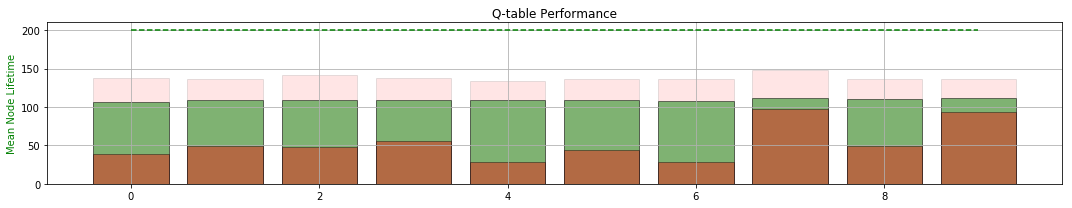

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  8990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  111.86
Validating... MEAN TIME:  113.945
Validating... MEAN TIME:  127.385
Validating... MEAN TIME:  134.73
Validating... MEAN TIME:  123.735
TRAINING TIME:0:00:34.271137


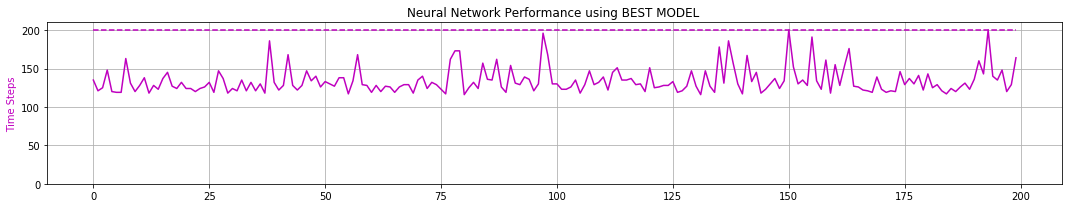

0 -max- [ 0.192  0.604  0.050  1.245  0.475]
0 -min- [-2.399 -3.161 -0.209 -0.841  0.426]

1 -max- [ 0.160  0.560  0.049  1.239  0.524]
1 -min- [-2.400 -3.156 -0.209 -0.947  0.476]

2 -max- [ 0.183  0.593  0.050  1.264  0.575]
2 -min- [-2.399 -3.143 -0.208 -1.002  0.525]

3 -max- [ 0.167  0.436  0.049  1.078  0.624]
3 -min- [-2.400 -3.151 -0.207 -0.947  0.575]

4 -max- [ 0.192  0.624  0.049  1.068  0.675]
4 -min- [-2.399 -3.273 -0.209 -0.955  0.625]

5 -max- [ 0.173  0.433  0.050  1.022  0.724]
5 -min- [-2.400 -3.168 -0.209 -1.135  0.675]

6 -max- [ 0.166  0.558  0.050  0.815  0.773]
6 -min- [-2.400 -3.133 -0.209 -0.958  0.726]

7 -max- [ 0.234  0.435  0.059  0.685  0.825]
7 -min- [-2.400 -3.151 -0.206 -0.950  0.775]

8 -max- [ 0.180  0.600  0.048  0.804  0.875]
8 -min- [-2.400 -3.287 -0.209 -0.885  0.826]

9 -max- [ 0.194  0.553  0.049  0.800  0.924]
9 -min- [-2.399 -3.345 -0.205 -0.950  0.875]



ITERATION # 9
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

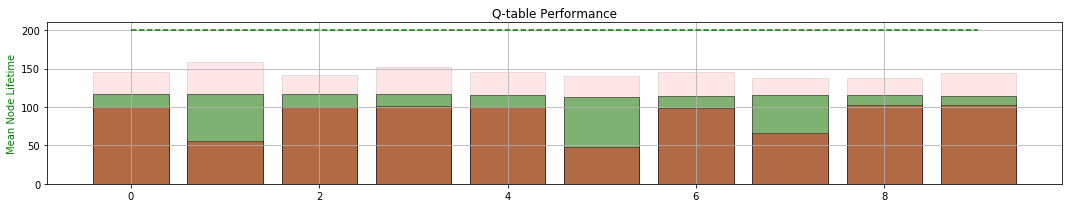

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  9990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  138.275
Validating... MEAN TIME:  133.41
Validating... MEAN TIME:  145.045
Validating... MEAN TIME:  127.33
Validating... MEAN TIME:  129.435
TRAINING TIME:0:00:36.667861


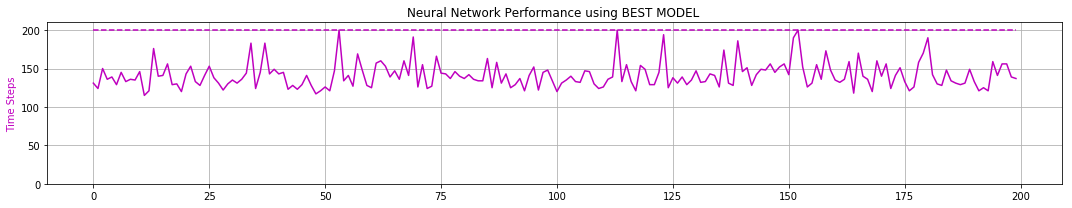

0 -max- [ 0.160  0.556  0.049  1.133  0.474]
0 -min- [-2.398 -2.972 -0.202 -0.938  0.426]

1 -max- [ 0.195  0.641  0.051  1.283  0.525]
1 -min- [-2.400 -3.154 -0.209 -1.195  0.476]

2 -max- [ 0.170  0.577  0.049  1.352  0.575]
2 -min- [-2.400 -3.087 -0.202 -1.170  0.525]

3 -max- [ 0.187  0.604  0.050  1.279  0.625]
3 -min- [-2.399 -2.971 -0.204 -0.953  0.575]

4 -max- [ 0.173  0.569  0.050  1.260  0.673]
4 -min- [-2.400 -3.117 -0.207 -0.898  0.625]

5 -max- [ 0.166  0.447  0.050  1.278  0.724]
5 -min- [-2.399 -2.963 -0.209 -1.075  0.675]

6 -max- [ 0.168  0.435  0.050  1.254  0.774]
6 -min- [-2.397 -2.968 -0.203 -1.037  0.726]

7 -max- [ 0.180  0.435  0.048  1.221  0.824]
7 -min- [-2.399 -2.971 -0.209 -1.162  0.775]

8 -max- [ 0.195  0.435  0.049  0.788  0.874]
8 -min- [-2.400 -2.977 -0.202 -1.006  0.825]

9 -max- [ 0.162  0.446  0.047  1.103  0.924]
9 -min- [-2.399 -2.963 -0.202 -0.937  0.876]



ITERATION # 10
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

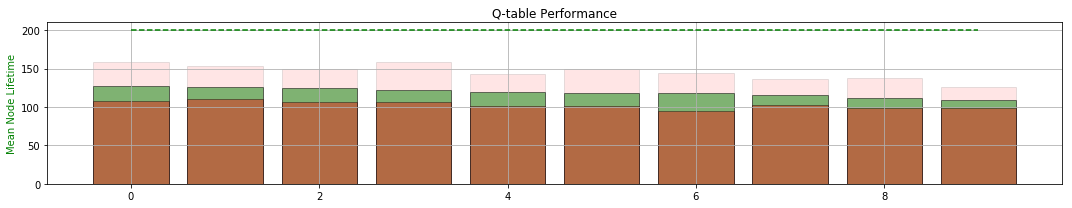

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  10990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  127.125
Validating... MEAN TIME:  134.405
Validating... MEAN TIME:  137.08
Validating... MEAN TIME:  128.675
Validating... MEAN TIME:  119.245
TRAINING TIME:0:00:35.347506


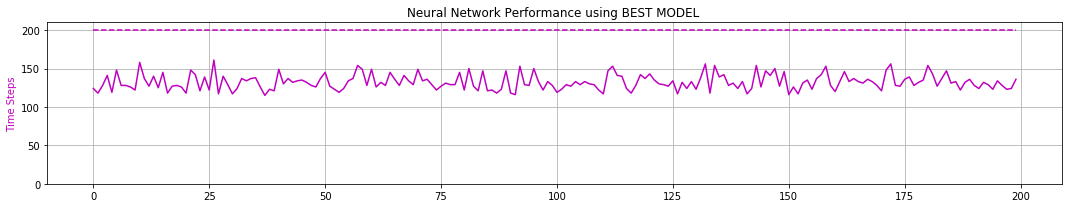

0 -max- [ 0.183  0.623  0.050  0.757  0.475]
0 -min- [-2.400 -2.986 -0.206 -1.207  0.425]

1 -max- [ 0.167  0.436  0.049  0.671  0.525]
1 -min- [-2.400 -2.972 -0.196 -0.902  0.475]

2 -max- [ 0.192  0.566  0.049  0.792  0.575]
2 -min- [-2.398 -3.114 -0.209 -0.935  0.525]

3 -max- [ 0.173  0.432  0.050  0.806  0.624]
3 -min- [-2.400 -3.115 -0.209 -0.928  0.576]

4 -max- [ 0.166  0.564  0.050  0.795  0.675]
4 -min- [-2.399 -3.091 -0.209 -0.990  0.626]

5 -max- [ 0.166  0.623  0.050  0.697  0.724]
5 -min- [-2.399 -3.150 -0.209 -0.941  0.675]

6 -max- [ 0.177  0.624  0.048  0.754  0.775]
6 -min- [-2.399 -3.091 -0.208 -0.841  0.725]

7 -max- [ 0.168  0.631  0.049  0.716  0.825]
7 -min- [-2.399 -3.116 -0.191 -0.888  0.775]

8 -max- [ 0.146  0.627  0.047  0.781  0.875]
8 -min- [-2.400 -3.117 -0.203 -0.900  0.825]

9 -max- [ 0.119  0.633  0.048  0.774  0.924]
9 -min- [-2.397 -3.117 -0.207 -0.904  0.876]



ITERATION # 11
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

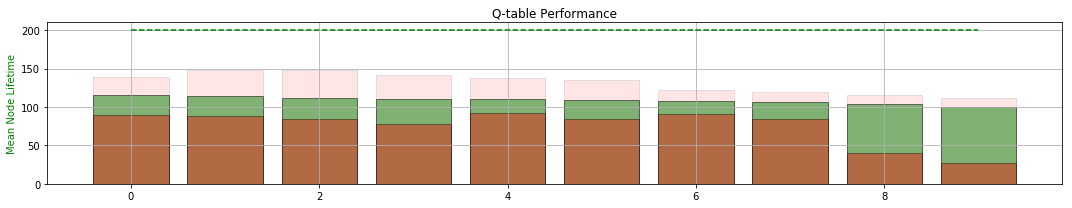

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  11990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  116.175
Validating... MEAN TIME:  125.305
Validating... MEAN TIME:  130.51
Validating... MEAN TIME:  131.265
Validating... MEAN TIME:  123.77
TRAINING TIME:0:00:34.660863


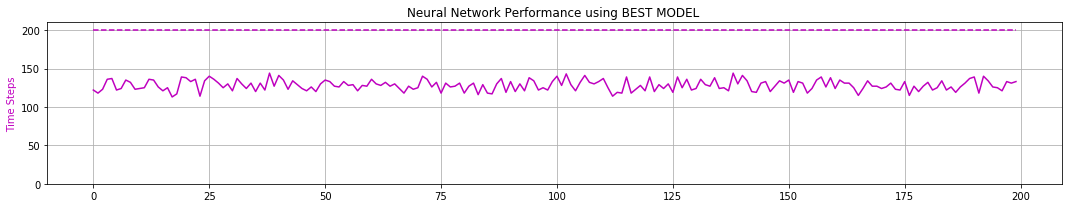

0 -max- [ 0.167  0.443  0.049  0.681  0.474]
0 -min- [-2.400 -3.111 -0.209 -0.933  0.425]

1 -max- [ 0.192  0.566  0.049  0.704  0.524]
1 -min- [-2.398 -3.102 -0.209 -0.845  0.475]

2 -max- [ 0.158  0.554  0.050  0.710  0.575]
2 -min- [-2.400 -3.115 -0.209 -0.938  0.525]

3 -max- [ 0.156  0.619  0.050  0.685  0.625]
3 -min- [-2.398 -3.130 -0.209 -1.099  0.575]

4 -max- [ 0.175  0.632  0.050  0.773  0.675]
4 -min- [-2.399 -3.098 -0.209 -1.112  0.625]

5 -max- [ 0.161  0.633  0.050  0.688  0.725]
5 -min- [-2.399 -3.088 -0.209 -0.884  0.675]

6 -max- [ 0.156  0.631  0.049  0.624  0.774]
6 -min- [-2.398 -3.165 -0.209 -0.899  0.725]

7 -max- [ 0.148  0.632  0.047  0.629  0.824]
7 -min- [-2.398 -3.107 -0.209 -0.909  0.775]

8 -max- [ 0.139  0.814  0.048  0.664  0.874]
8 -min- [-2.399 -3.128 -0.209 -1.179  0.827]

9 -max- [ 0.154  0.636  0.048  0.815  0.924]
9 -min- [-2.398 -3.135 -0.209 -1.010  0.875]



ITERATION # 12
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

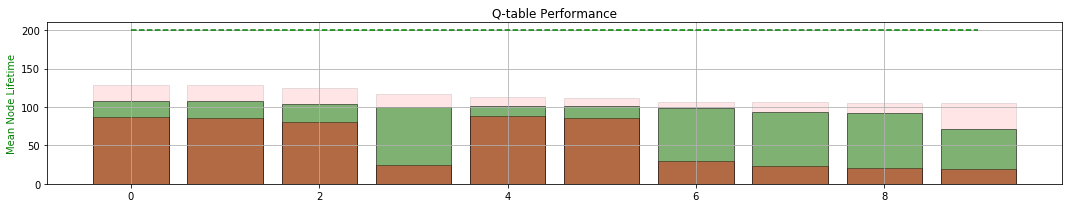

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  12990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  126.35
Validating... MEAN TIME:  111.0
Validating... MEAN TIME:  116.17
Validating... MEAN TIME:  115.295
Validating... MEAN TIME:  114.1
TRAINING TIME:0:00:32.135863


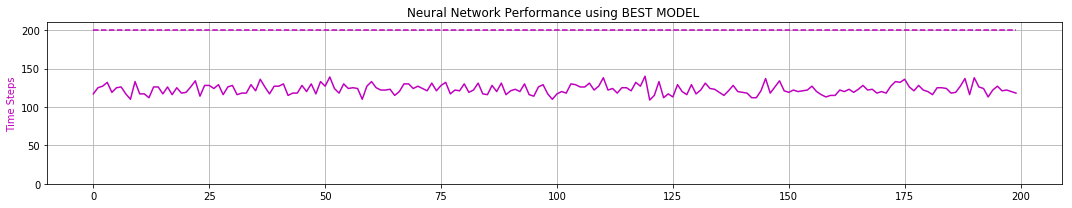

0 -max- [ 0.168  0.634  0.049  0.767  0.474]
0 -min- [-2.398 -3.164 -0.209 -0.932  0.425]

1 -max- [ 0.169  0.630  0.050  0.752  0.524]
1 -min- [-2.397 -3.117 -0.209 -0.990  0.475]

2 -max- [ 0.159  0.766  0.050  0.764  0.575]
2 -min- [-2.396 -3.116 -0.209 -1.201  0.526]

3 -max- [ 0.173  0.736  0.052  0.754  0.625]
3 -min- [-2.399 -3.106 -0.209 -1.165  0.575]

4 -max- [ 0.189  0.765  0.048  0.862  0.673]
4 -min- [-2.400 -3.122 -0.209 -1.220  0.625]

5 -max- [ 0.191  0.634  0.049  0.664  0.724]
5 -min- [-2.400 -3.128 -0.209 -1.011  0.675]

6 -max- [ 0.185  0.782  0.047  0.749  0.775]
6 -min- [-2.400 -3.131 -0.209 -1.211  0.725]

7 -max- [ 0.175  0.753  0.048  0.684  0.823]
7 -min- [-2.398 -3.301 -0.209 -1.220  0.775]

8 -max- [ 0.185  0.834  0.048  0.732  0.875]
8 -min- [-2.399 -3.141 -0.209 -1.220  0.827]

9 -max- [ 0.169  0.789  0.049  0.827  0.925]
9 -min- [-2.398 -3.158 -0.209 -1.118  0.875]



ITERATION # 13
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

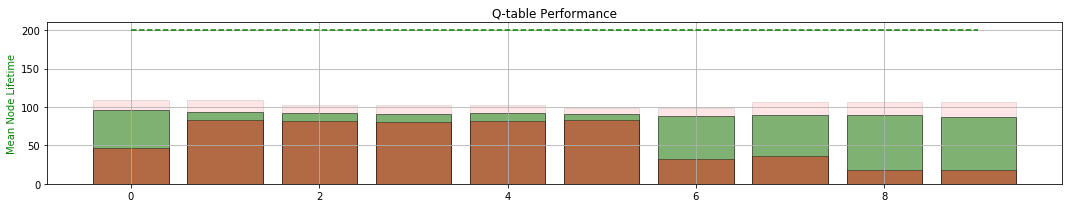

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  13990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  109.035
Validating... MEAN TIME:  109.73
Validating... MEAN TIME:  114.115
Validating... MEAN TIME:  124.775
Validating... MEAN TIME:  111.255
TRAINING TIME:0:00:31.385735


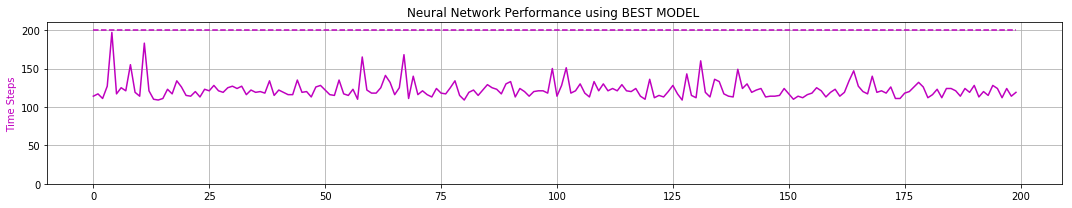

0 -max- [ 0.149  0.790  0.050  0.715  0.474]
0 -min- [-2.346 -2.967 -0.209 -1.114  0.425]

1 -max- [ 0.164  0.636  0.050  0.712  0.525]
1 -min- [-1.934 -2.426 -0.209 -1.214  0.475]

2 -max- [ 0.164  0.633  0.050  0.701  0.574]
2 -min- [-1.926 -2.429 -0.209 -0.962  0.525]

3 -max- [ 0.181  0.810  0.054  0.701  0.625]
3 -min- [-1.905 -2.520 -0.209 -1.174  0.576]

4 -max- [ 0.191  0.785  0.049  0.664  0.675]
4 -min- [-2.118 -2.589 -0.209 -1.171  0.627]

5 -max- [ 0.185  0.636  0.047  0.687  0.725]
5 -min- [-1.885 -2.420 -0.209 -1.007  0.675]

6 -max- [ 0.161  0.823  0.048  0.814  0.774]
6 -min- [-2.355 -2.952 -0.209 -1.237  0.726]

7 -max- [ 0.178  0.822  0.048  0.800  0.825]
7 -min- [-2.381 -3.096 -0.209 -1.227  0.775]

8 -max- [ 0.161  0.768  0.049  0.684  0.874]
8 -min- [-2.395 -2.974 -0.209 -1.247  0.825]

9 -max- [ 0.181  0.997  0.050  0.697  0.925]
9 -min- [-2.396 -3.110 -0.209 -1.553  0.875]



ITERATION # 14
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

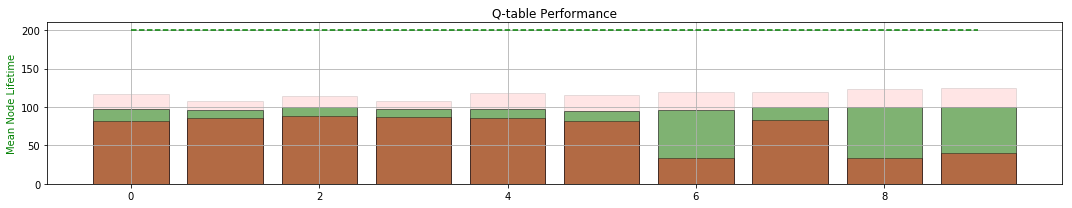

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  14990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  102.085
Validating... MEAN TIME:  114.505
Validating... MEAN TIME:  115.64
Validating... MEAN TIME:  155.065
Validating... MEAN TIME:  131.35
TRAINING TIME:0:00:33.393331


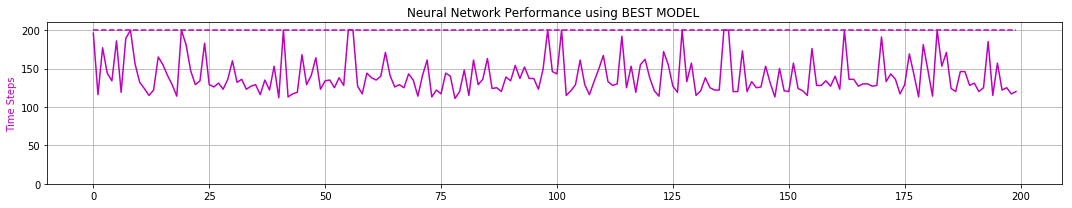

0 -max- [ 0.140  0.632  0.050  0.723  0.475]
0 -min- [-1.810 -2.228 -0.209 -0.942  0.426]

1 -max- [ 0.154  0.785  0.050  0.678  0.524]
1 -min- [-1.897 -2.230 -0.209 -1.237  0.476]

2 -max- [ 0.161  0.970  0.048  0.831  0.575]
2 -min- [-1.862 -2.331 -0.209 -1.437  0.525]

3 -max- [ 0.166  0.635  0.049  0.687  0.624]
3 -min- [-1.853 -2.422 -0.209 -0.958  0.576]

4 -max- [ 0.151  0.632  0.047  0.842  0.674]
4 -min- [-2.388 -2.944 -0.209 -1.215  0.626]

5 -max- [ 0.140  0.635  0.048  0.714  0.725]
5 -min- [-2.397 -3.163 -0.209 -1.094  0.676]

6 -max- [ 0.165  0.638  0.053  0.834  0.775]
6 -min- [-2.395 -3.102 -0.209 -0.981  0.726]

7 -max- [ 0.145  0.746  0.053  0.844  0.824]
7 -min- [-2.398 -3.122 -0.209 -1.101  0.775]

8 -max- [ 0.168  0.787  0.050  0.820  0.874]
8 -min- [-2.399 -3.145 -0.209 -1.289  0.825]

9 -max- [ 0.180  0.636  0.051  0.837  0.925]
9 -min- [-2.398 -3.145 -0.209 -0.989  0.875]



ITERATION # 15
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

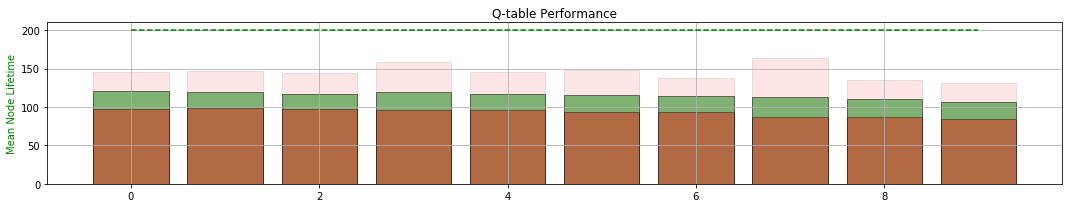

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  15990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  117.625
Validating... MEAN TIME:  108.885
Validating... MEAN TIME:  139.79
Validating... MEAN TIME:  116.685
Validating... MEAN TIME:  157.55
TRAINING TIME:0:00:35.135766


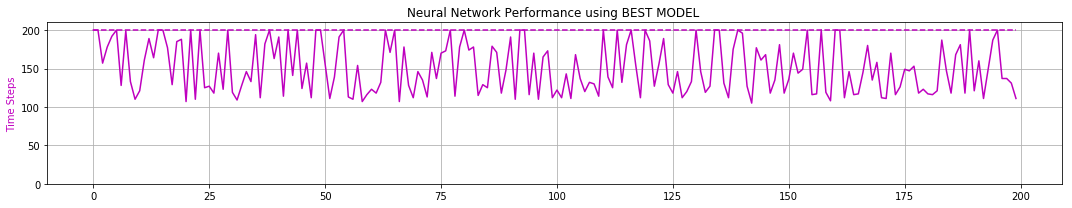

0 -max- [ 0.140  0.633  0.050  0.775  0.475]
0 -min- [-2.400 -2.941 -0.209 -1.069  0.425]

1 -max- [ 0.144  0.634  0.048  0.779  0.524]
1 -min- [-2.400 -2.936 -0.209 -1.207  0.476]

2 -max- [ 0.142  0.633  0.049  0.739  0.575]
2 -min- [-2.399 -2.942 -0.209 -0.981  0.525]

3 -max- [ 0.145  0.640  0.047  0.725  0.624]
3 -min- [-2.400 -3.168 -0.209 -1.244  0.575]

4 -max- [ 0.143  0.729  0.048  0.740  0.674]
4 -min- [-2.397 -3.136 -0.209 -1.153  0.625]

5 -max- [ 0.139  0.631  0.048  0.969  0.725]
5 -min- [-2.398 -3.151 -0.209 -1.214  0.675]

6 -max- [ 0.145  0.765  0.049  0.824  0.773]
6 -min- [-2.385 -3.152 -0.209 -1.283  0.725]

7 -max- [ 0.153  0.827  0.050  0.805  0.824]
7 -min- [-2.399 -2.949 -0.209 -1.222  0.775]

8 -max- [ 0.150  0.650  0.048  0.810  0.874]
8 -min- [-2.396 -3.117 -0.209 -1.205  0.826]

9 -max- [ 0.168  0.643  0.048  0.825  0.925]
9 -min- [-2.384 -3.062 -0.209 -1.286  0.875]



ITERATION # 16
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

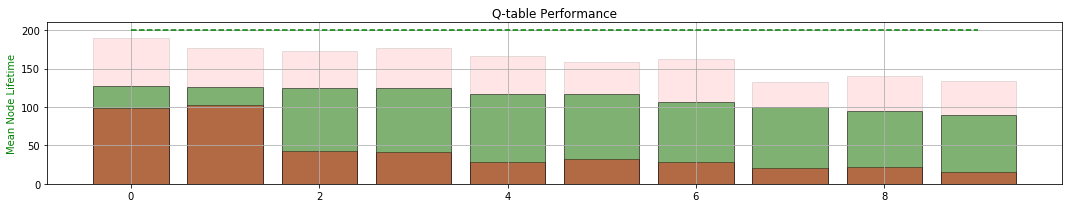

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  16990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  127.26
Validating... MEAN TIME:  105.16
Validating... MEAN TIME:  149.43
Validating... MEAN TIME:  159.545
Validating... MEAN TIME:  108.425
TRAINING TIME:0:00:34.377128


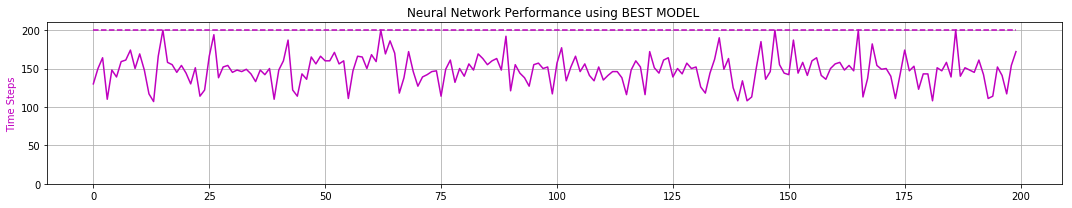

0 -max- [ 0.210  0.633  0.048  1.069  0.475]
0 -min- [-2.008 -2.735 -0.209 -1.188  0.425]

1 -max- [ 0.227  0.634  0.049  0.864  0.524]
1 -min- [-1.892 -2.392 -0.209 -1.137  0.475]

2 -max- [ 0.218  0.628  0.047  0.852  0.574]
2 -min- [-1.872 -2.396 -0.209 -1.075  0.525]

3 -max- [ 0.207  0.636  0.053  0.851  0.625]
3 -min- [-2.228 -2.748 -0.209 -1.030  0.575]

4 -max- [ 0.208  0.742  0.048  0.839  0.675]
4 -min- [-2.362 -2.898 -0.209 -1.212  0.625]

5 -max- [ 0.181  0.626  0.049  0.865  0.724]
5 -min- [-1.887 -2.567 -0.209 -1.031  0.675]

6 -max- [ 0.243  0.830  0.050  0.956  0.775]
6 -min- [-1.971 -2.587 -0.209 -1.332  0.725]

7 -max- [ 0.219  0.650  0.048  0.970  0.824]
7 -min- [-1.899 -2.693 -0.209 -1.310  0.776]

8 -max- [ 0.224  0.830  0.048  1.080  0.875]
8 -min- [-1.933 -2.697 -0.209 -1.444  0.827]

9 -max- [ 0.205  0.812  0.046  0.868  0.924]
9 -min- [-2.345 -3.076 -0.209 -1.570  0.876]



ITERATION # 17
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

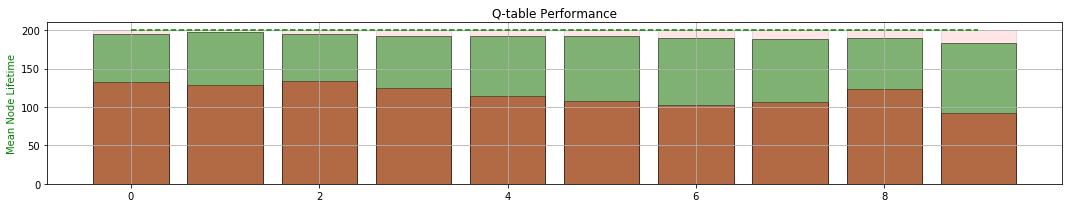

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  17220
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  167.155
Validating... MEAN TIME:  112.15
Validating... MEAN TIME:  127.95
Validating... MEAN TIME:  105.565
Validating... MEAN TIME:  178.89
TRAINING TIME:0:00:36.926083


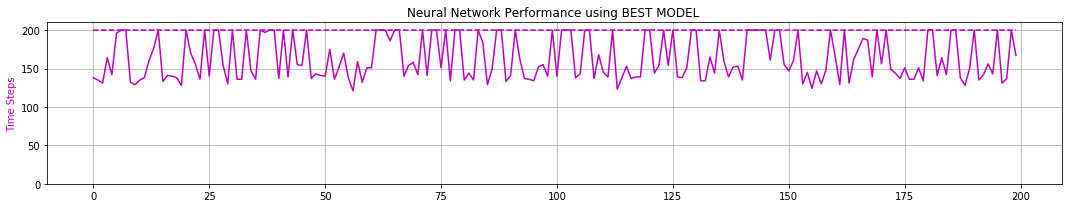

0 -max- [ 0.159  0.705  0.098  0.831  0.474]
0 -min- [-2.174 -2.388 -0.209 -1.026  0.426]

1 -max- [ 0.144  0.579  0.066  0.815  0.525]
1 -min- [-2.075 -2.389 -0.208 -1.062  0.475]

2 -max- [ 0.202  0.756  0.067  0.773  0.574]
2 -min- [-2.073 -2.390 -0.209 -0.982  0.526]

3 -max- [ 0.229  0.888  0.073  0.955  0.625]
3 -min- [-2.135 -2.378 -0.209 -1.034  0.575]

4 -max- [ 0.160  0.702  0.067  0.863  0.675]
4 -min- [-2.145 -2.565 -0.209 -1.007  0.625]

5 -max- [ 1.116  0.798  0.068  0.921  0.724]
5 -min- [-2.153 -2.581 -0.209 -1.320  0.675]

6 -max- [ 1.491  1.150  0.090  0.869  0.775]
6 -min- [-2.133 -2.581 -0.209 -1.029  0.726]

7 -max- [ 0.392  0.600  0.048  0.861  0.825]
7 -min- [-2.207 -2.762 -0.209 -1.171  0.775]

8 -max- [ 1.105  0.988  0.053  0.868  0.874]
8 -min- [-2.198 -2.557 -0.209 -1.282  0.826]

9 -max- [ 1.954  1.488  0.135  0.951  0.925]
9 -min- [-2.039 -2.537 -0.209 -1.174  0.875]



ITERATION # 18
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

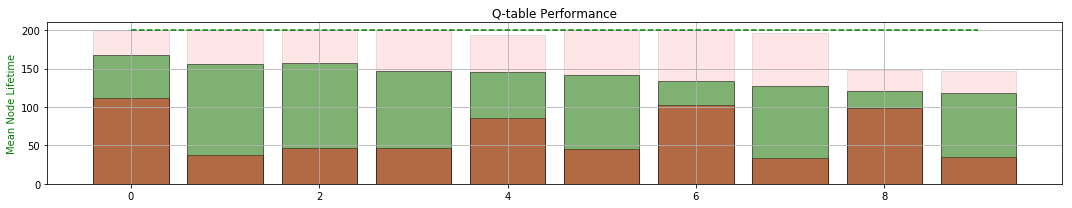

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  18173
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  183.18
Validating... MEAN TIME:  194.27
Validating... MEAN TIME:  108.33
Validating... MEAN TIME:  196.205
Validating... MEAN TIME:  143.455
TRAINING TIME:0:00:42.592893


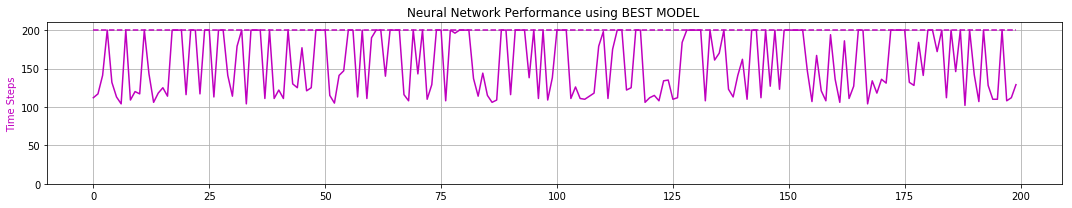

0 -max- [ 0.180  0.638  0.054  1.289  0.475]
0 -min- [-2.399 -2.777 -0.209 -1.577  0.425]

1 -max- [ 0.158  0.787  0.048  1.288  0.524]
1 -min- [-2.399 -2.973 -0.209 -1.332  0.476]

2 -max- [ 0.181  0.802  0.048  1.292  0.575]
2 -min- [-2.399 -2.969 -0.209 -1.390  0.525]

3 -max- [ 0.158  0.767  0.049  1.292  0.623]
3 -min- [-2.399 -2.945 -0.209 -1.413  0.575]

4 -max- [ 0.180  0.779  0.050  1.488  0.675]
4 -min- [-2.400 -3.078 -0.209 -1.567  0.625]

5 -max- [ 0.190  0.813  0.048  1.296  0.725]
5 -min- [-2.399 -2.769 -0.209 -1.341  0.675]

6 -max- [ 0.166  0.817  0.048  1.471  0.775]
6 -min- [-2.398 -3.099 -0.209 -1.369  0.725]

7 -max- [ 0.169  0.829  0.046  1.467  0.824]
7 -min- [-2.399 -2.967 -0.209 -1.511  0.775]

8 -max- [ 0.172  0.957  0.049  1.295  0.875]
8 -min- [-2.399 -3.109 -0.209 -1.599  0.826]

9 -max- [ 0.176  0.827  0.049  1.636  0.924]
9 -min- [-2.400 -3.081 -0.209 -1.700  0.876]



ITERATION # 19
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

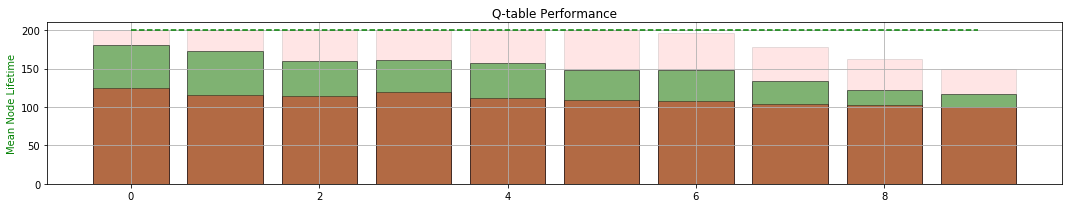

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  19058
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.825
Validating... MEAN TIME:  175.92
Validating... MEAN TIME:  194.045
Validating... MEAN TIME:  174.945
TRAINING TIME:0:00:48.259539


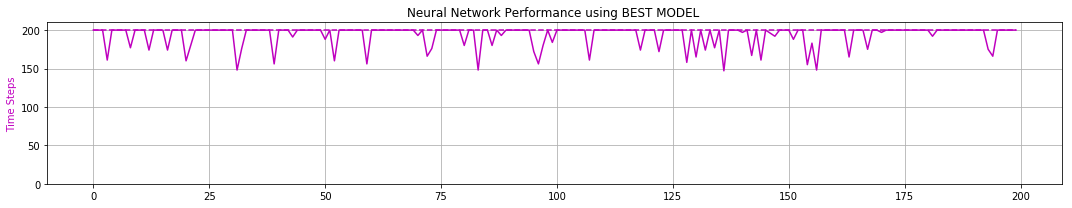

0 -max- [ 0.141  0.819  0.207  1.693  0.474]
0 -min- [-2.400 -3.027 -0.209 -2.200  0.426]

1 -max- [ 0.161  0.834  0.198  1.748  0.524]
1 -min- [-2.400 -3.340 -0.205 -2.209  0.476]

2 -max- [ 0.150  0.819  0.209  1.719  0.575]
2 -min- [-2.400 -3.182 -0.208 -2.191  0.526]

3 -max- [ 0.161  0.826  0.207  1.723  0.623]
3 -min- [-2.400 -3.168 -0.206 -2.192  0.575]

4 -max- [ 0.152  0.828  0.207  1.780  0.674]
4 -min- [-2.400 -3.351 -0.208 -2.229  0.625]

5 -max- [ 0.151  0.978  0.206  1.780  0.724]
5 -min- [-2.399 -3.208 -0.209 -2.261  0.675]

6 -max- [ 0.145  0.990  0.209  1.712  0.773]
6 -min- [-2.399 -3.341 -0.208 -2.289  0.726]

7 -max- [ 0.152  0.829  0.202  1.983  0.825]
7 -min- [-2.400 -3.594 -0.209 -2.271  0.775]

8 -max- [ 0.168  0.827  0.200  2.054  0.875]
8 -min- [-2.400 -3.702 -0.209 -2.401  0.825]

9 -max- [ 0.180  1.007  0.200  2.109  0.924]
9 -min- [-2.400 -3.862 -0.203 -2.326  0.875]



ITERATION # 20
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

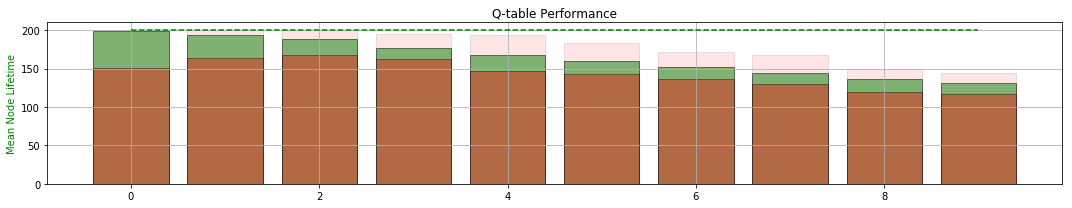

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  19887
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  156.015
Validating... MEAN TIME:  127.43
Validating... MEAN TIME:  195.375
Validating... MEAN TIME:  138.08
Validating... MEAN TIME:  173.675
TRAINING TIME:0:00:41.085190


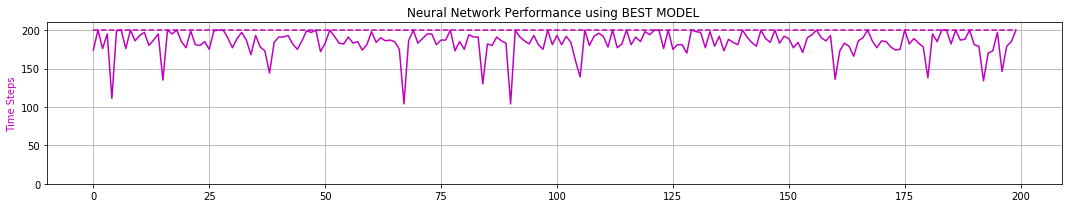

0 -max- [ 0.141  0.801  0.052  1.125  0.474]
0 -min- [-2.395 -2.041 -0.160 -1.202  0.426]

1 -max- [ 0.116  0.747  0.049  0.895  0.525]
1 -min- [-2.400 -2.069 -0.143 -1.167  0.476]

2 -max- [ 0.120  0.757  0.050  1.090  0.575]
2 -min- [-2.400 -2.016 -0.138 -1.196  0.525]

3 -max- [ 0.121  0.744  0.056  1.006  0.625]
3 -min- [-2.400 -2.026 -0.139 -1.087  0.576]

4 -max- [ 0.115  0.806  0.048  1.080  0.675]
4 -min- [-2.400 -2.374 -0.144 -1.153  0.626]

5 -max- [ 0.109  0.821  0.046  0.975  0.724]
5 -min- [-2.400 -2.228 -0.131 -1.128  0.676]

6 -max- [ 0.160  0.826  0.049  1.050  0.775]
6 -min- [-2.400 -2.212 -0.160 -1.174  0.725]

7 -max- [ 0.137  0.985  0.049  1.274  0.825]
7 -min- [-2.399 -2.392 -0.199 -1.427  0.776]

8 -max- [ 0.153  1.011  0.050  1.272  0.875]
8 -min- [-2.400 -2.426 -0.197 -1.423  0.825]

9 -max- [ 0.134  0.955  0.048  1.207  0.924]
9 -min- [-2.399 -2.570 -0.200 -1.461  0.875]



ITERATION # 21
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

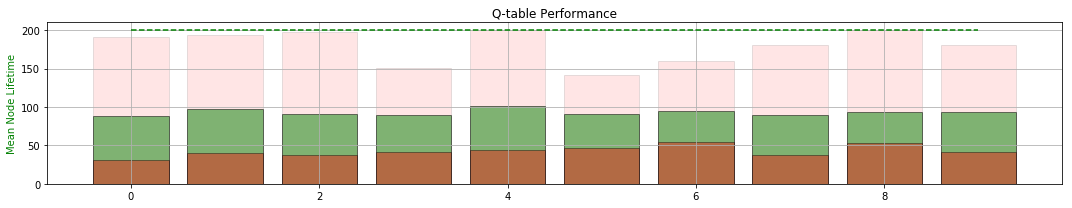

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  20885
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  187.605
Validating... MEAN TIME:  172.415
Validating... MEAN TIME:  171.25
TRAINING TIME:0:00:46.660946


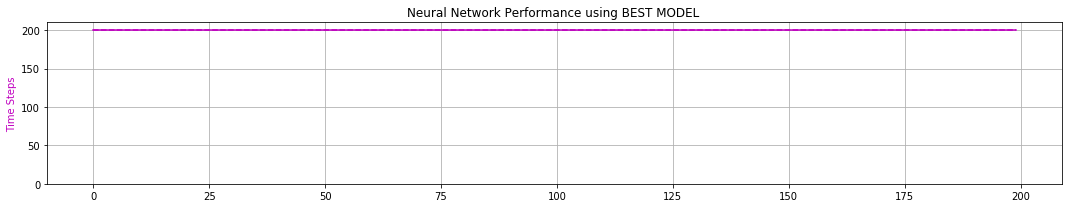

0 -max- [ 0.423  0.932  0.083  0.806  0.475]
0 -min- [-0.187 -0.709 -0.209 -1.078  0.426]

1 -max- [ 0.380  0.934  0.064  0.759  0.525]
1 -min- [-0.160 -0.708 -0.209 -1.136  0.475]

2 -max- [ 0.388  0.944  0.088  0.763  0.575]
2 -min- [-0.244 -0.781 -0.209 -1.114  0.525]

3 -max- [ 0.385  0.947  0.080  0.756  0.624]
3 -min- [-0.134 -0.783 -0.209 -1.231  0.575]

4 -max- [ 0.421  1.006  0.061  0.746  0.675]
4 -min- [-0.156 -0.765 -0.209 -1.320  0.626]

5 -max- [ 0.441  1.184  0.095  0.825  0.725]
5 -min- [-0.129 -0.752 -0.209 -1.350  0.676]

6 -max- [ 0.479  1.139  0.087  0.760  0.775]
6 -min- [-0.153 -0.885 -0.209 -1.352  0.725]

7 -max- [ 0.441  1.017  0.084  0.794  0.825]
7 -min- [-0.151 -0.707 -0.209 -1.360  0.777]

8 -max- [ 0.526  1.132  0.127  1.321  0.874]
8 -min- [-0.257 -0.762 -0.209 -1.307  0.825]

9 -max- [ 0.422  1.119  0.105  0.965  0.925]
9 -min- [-0.188 -0.723 -0.209 -1.332  0.875]



ITERATION # 22
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

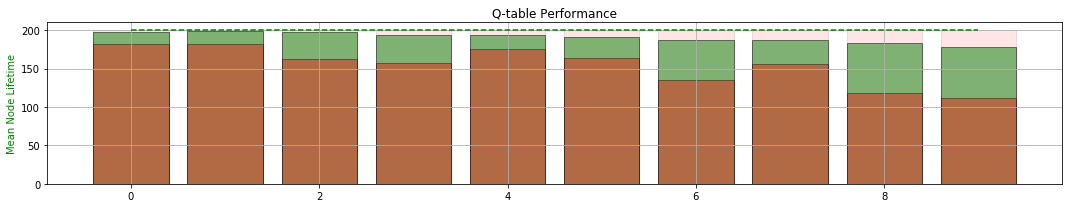

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  21459
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  191.13
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.14
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.227895


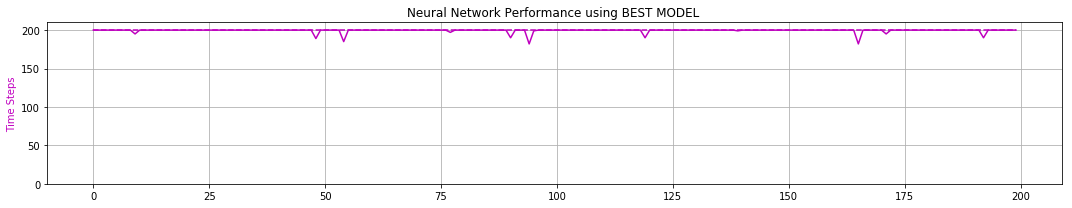

0 -max- [ 0.147  0.833  0.053  1.145  0.475]
0 -min- [-2.399 -2.008 -0.163 -1.325  0.426]

1 -max- [ 0.138  0.828  0.060  1.204  0.525]
1 -min- [-2.400 -2.020 -0.166 -1.508  0.476]

2 -max- [ 0.146  0.998  0.071  1.193  0.575]
2 -min- [-2.398 -2.018 -0.174 -1.592  0.525]

3 -max- [ 0.140  0.829  0.085  1.095  0.625]
3 -min- [-2.400 -2.039 -0.171 -1.326  0.576]

4 -max- [ 0.159  1.007  0.070  1.160  0.674]
4 -min- [-2.400 -2.033 -0.161 -1.414  0.626]

5 -max- [ 0.156  0.989  0.090  1.259  0.725]
5 -min- [-2.398 -2.030 -0.170 -1.399  0.675]

6 -max- [ 0.175  0.998  0.067  1.024  0.775]
6 -min- [-2.399 -2.010 -0.158 -1.509  0.725]

7 -max- [ 0.138  0.955  0.060  0.950  0.823]
7 -min- [-2.400 -1.996 -0.137 -1.461  0.775]

8 -max- [ 0.135  0.962  0.061  1.036  0.875]
8 -min- [-2.400 -2.037 -0.164 -1.503  0.826]

9 -max- [ 0.168  1.008  0.075  0.851  0.925]
9 -min- [-2.400 -2.354 -0.185 -1.501  0.876]



ITERATION # 23
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

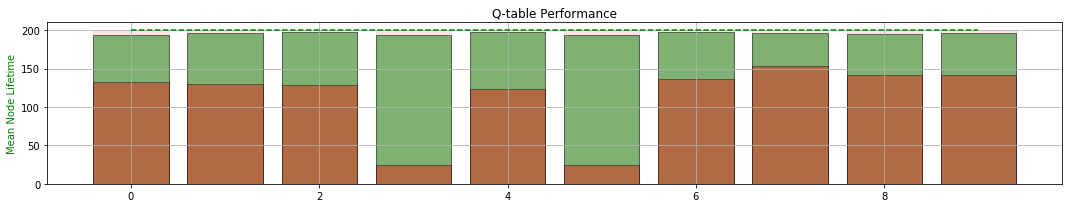

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  21593
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.96
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  198.82
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.945
TRAINING TIME:0:00:49.235905


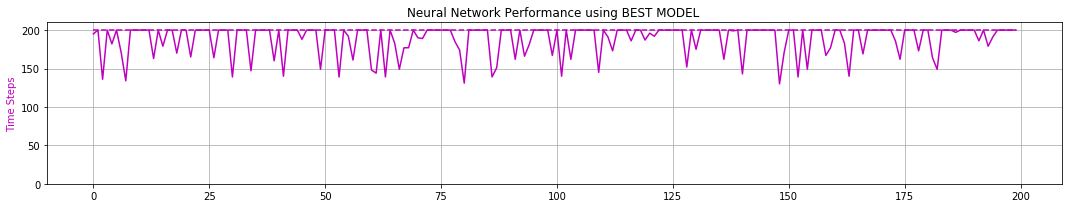

0 -max- [ 0.203  0.985  0.091  1.099  0.475]
0 -min- [-2.393 -2.015 -0.191 -1.445  0.425]

1 -max- [ 0.172  0.995  0.098  1.144  0.525]
1 -min- [-2.399 -2.216 -0.189 -1.476  0.476]

2 -max- [ 0.219  1.016  0.100  1.201  0.574]
2 -min- [-2.387 -2.175 -0.193 -1.442  0.526]

3 -max- [ 0.214  1.168  0.095  1.216  0.625]
3 -min- [-2.398 -2.330 -0.209 -1.609  0.576]

4 -max- [ 0.375  1.163  0.099  1.187  0.675]
4 -min- [-2.397 -2.340 -0.192 -1.567  0.626]

5 -max- [ 0.389  1.370  0.109  1.269  0.725]
5 -min- [-2.399 -2.385 -0.201 -1.910  0.677]

6 -max- [ 0.551  1.146  0.096  1.253  0.775]
6 -min- [-2.400 -2.744 -0.208 -1.598  0.725]

7 -max- [ 0.531  1.204  0.095  1.245  0.824]
7 -min- [-2.393 -2.741 -0.204 -1.627  0.775]

8 -max- [ 0.568  1.140  0.104  1.289  0.874]
8 -min- [-2.391 -2.393 -0.208 -1.590  0.826]

9 -max- [ 0.577  1.151  0.097  1.126  0.925]
9 -min- [-2.385 -2.729 -0.207 -1.606  0.875]



ITERATION # 24
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

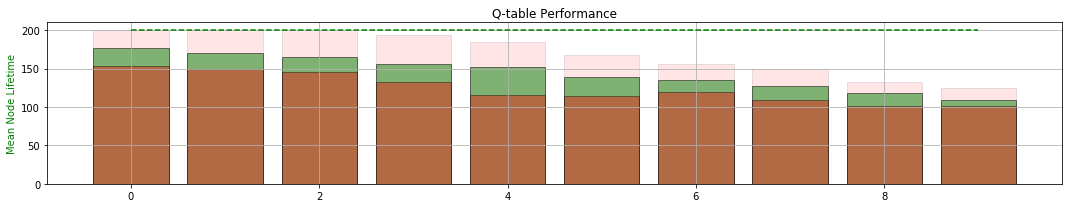

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  22579
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  196.875
Validating... MEAN TIME:  195.75
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.340336


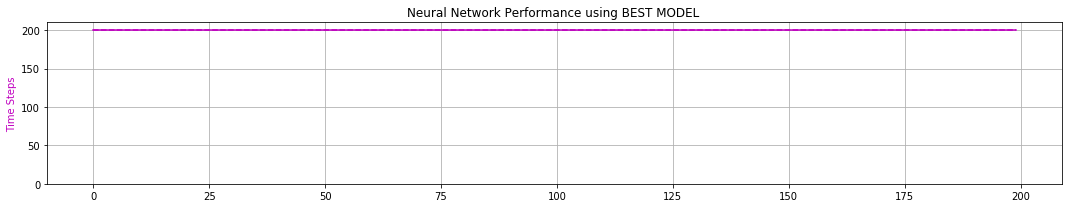

0 -max- [ 0.175  1.008  0.056  1.108  0.475]
0 -min- [-2.400 -1.701 -0.181 -1.479  0.425]

1 -max- [ 0.157  1.020  0.058  1.130  0.524]
1 -min- [-2.400 -1.836 -0.181 -1.615  0.475]

2 -max- [ 0.159  0.992  0.058  1.085  0.575]
2 -min- [-2.400 -1.910 -0.162 -1.460  0.527]

3 -max- [ 0.145  1.022  0.056  1.073  0.625]
3 -min- [-2.400 -1.860 -0.178 -1.477  0.575]

4 -max- [ 0.159  1.021  0.050  0.992  0.675]
4 -min- [-2.400 -2.021 -0.182 -1.490  0.625]

5 -max- [ 0.138  0.924  0.048  0.961  0.725]
5 -min- [-2.399 -2.053 -0.192 -1.434  0.675]

6 -max- [ 0.165  1.026  0.046  0.854  0.774]
6 -min- [-2.400 -2.084 -0.176 -1.505  0.725]

7 -max- [ 0.164  0.826  0.049  0.826  0.825]
7 -min- [-2.399 -2.417 -0.179 -1.223  0.775]

8 -max- [ 0.161  0.830  0.050  0.951  0.875]
8 -min- [-2.399 -2.617 -0.207 -1.236  0.825]

9 -max- [ 0.170  0.828  0.050  1.096  0.925]
9 -min- [-2.400 -2.784 -0.199 -1.222  0.876]



ITERATION # 25
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

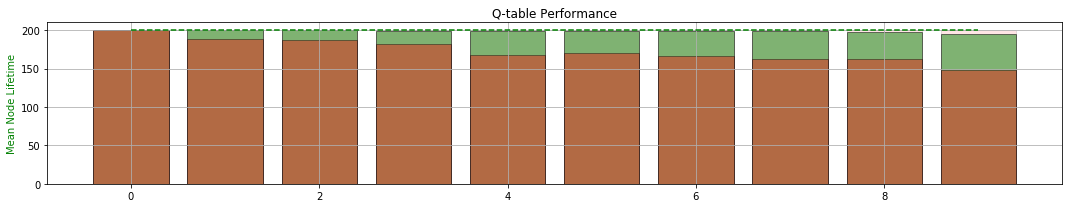

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  22664
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.725
Validating... MEAN TIME:  189.175
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.97
Validating... MEAN TIME:  186.635
TRAINING TIME:0:00:47.848649


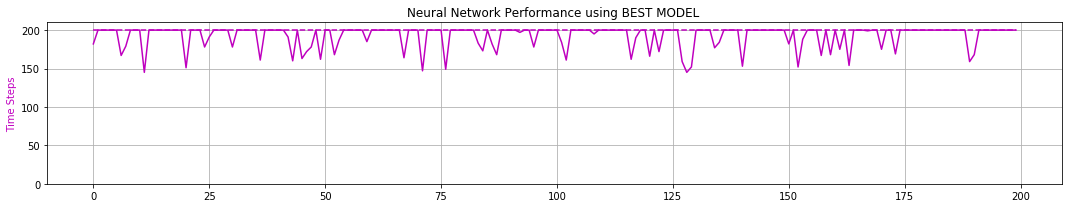

0 -max- [ 0.200  1.001  0.079  1.155  0.475]
0 -min- [-2.139 -1.695 -0.180 -1.584  0.425]

1 -max- [ 0.298  1.198  0.079  1.177  0.525]
1 -min- [-2.389 -1.673 -0.169 -1.607  0.477]

2 -max- [ 0.380  0.987  0.102  1.191  0.575]
2 -min- [-2.310 -1.708 -0.205 -1.641  0.527]

3 -max- [ 0.491  1.007  0.086  1.215  0.625]
3 -min- [-2.392 -1.710 -0.172 -1.498  0.576]

4 -max- [ 0.600  1.014  0.077  1.209  0.675]
4 -min- [-2.395 -1.820 -0.173 -1.490  0.626]

5 -max- [ 0.607  0.936  0.072  1.225  0.724]
5 -min- [-2.392 -1.710 -0.172 -1.338  0.676]

6 -max- [ 0.647  1.106  0.077  1.080  0.774]
6 -min- [-2.392 -1.707 -0.152 -1.426  0.726]

7 -max- [ 0.826  1.001  0.069  1.214  0.824]
7 -min- [-2.394 -1.829 -0.172 -1.292  0.775]

8 -max- [ 0.775  1.329  0.067  1.227  0.875]
8 -min- [-2.397 -1.855 -0.192 -1.415  0.825]

9 -max- [ 0.765  1.124  0.085  1.394  0.925]
9 -min- [-2.400 -2.019 -0.206 -1.502  0.876]



ITERATION # 26
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

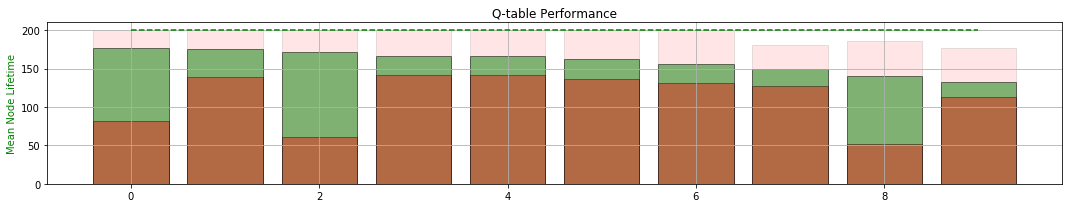

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  23596
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  198.29
Validating... MEAN TIME:  169.89
Validating... MEAN TIME:  185.665
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  197.22
TRAINING TIME:0:00:47.427310


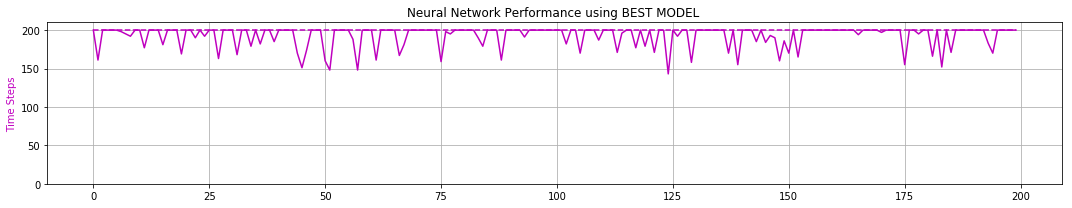

0 -max- [ 0.152  0.829  0.075  1.338  0.475]
0 -min- [-2.400 -2.011 -0.207 -1.605  0.426]

1 -max- [ 0.147  0.993  0.101  1.263  0.525]
1 -min- [-2.400 -2.228 -0.179 -1.603  0.477]

2 -max- [ 0.178  1.140  0.092  1.352  0.575]
2 -min- [-2.400 -1.886 -0.187 -1.684  0.525]

3 -max- [ 0.133  1.004  0.092  1.296  0.624]
3 -min- [-2.400 -2.067 -0.187 -1.607  0.575]

4 -max- [ 0.128  0.828  0.078  1.214  0.674]
4 -min- [-2.400 -2.159 -0.178 -1.529  0.625]

5 -max- [ 0.150  1.018  0.099  1.035  0.725]
5 -min- [-2.400 -2.225 -0.169 -1.520  0.676]

6 -max- [ 0.124  0.928  0.065  0.946  0.775]
6 -min- [-2.400 -2.167 -0.143 -1.514  0.725]

7 -max- [ 0.149  0.957  0.050  0.868  0.825]
7 -min- [-2.400 -2.225 -0.156 -1.547  0.775]

8 -max- [ 0.156  0.980  0.057  1.201  0.875]
8 -min- [-2.400 -2.251 -0.205 -1.607  0.825]

9 -max- [ 0.134  0.990  0.050  1.006  0.925]
9 -min- [-2.400 -2.248 -0.197 -1.457  0.876]



ITERATION # 27
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

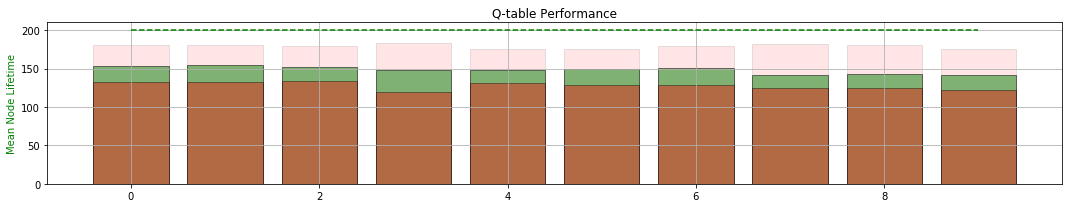

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  24596
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  163.57
Validating... MEAN TIME:  195.945
Validating... MEAN TIME:  174.8
Validating... MEAN TIME:  144.015
Validating... MEAN TIME:  166.425
TRAINING TIME:0:00:43.446269


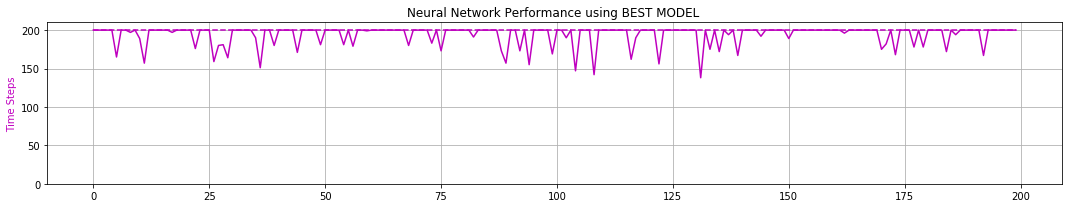

0 -max- [ 0.168  1.021  0.049  1.176  0.475]
0 -min- [-2.400 -2.062 -0.184 -1.455  0.425]

1 -max- [ 0.157  0.935  0.050  1.258  0.525]
1 -min- [-2.400 -2.047 -0.193 -1.625  0.475]

2 -max- [ 0.155  0.966  0.056  1.268  0.574]
2 -min- [-2.399 -2.016 -0.198 -1.376  0.526]

3 -max- [ 0.136  1.021  0.067  1.259  0.625]
3 -min- [-2.400 -2.059 -0.202 -1.487  0.575]

4 -max- [ 0.164  0.937  0.049  1.223  0.675]
4 -min- [-2.400 -1.999 -0.174 -1.627  0.625]

5 -max- [ 0.160  0.830  0.050  1.206  0.725]
5 -min- [-2.400 -2.063 -0.184 -1.332  0.675]

6 -max- [ 0.155  0.828  0.054  1.135  0.773]
6 -min- [-2.400 -2.173 -0.178 -1.335  0.725]

7 -max- [ 0.154  0.982  0.049  1.147  0.825]
7 -min- [-2.400 -2.352 -0.165 -1.481  0.775]

8 -max- [ 0.134  1.005  0.052  0.981  0.875]
8 -min- [-2.399 -2.190 -0.168 -1.431  0.825]

9 -max- [ 0.135  1.023  0.049  1.024  0.925]
9 -min- [-2.400 -2.347 -0.164 -1.405  0.875]



ITERATION # 28
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

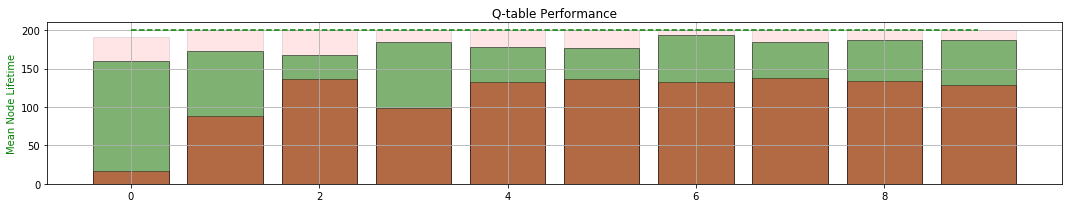

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  25276
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  192.745
Validating... MEAN TIME:  155.945
Validating... MEAN TIME:  174.305
Validating... MEAN TIME:  151.705
Validating... MEAN TIME:  193.825
TRAINING TIME:0:00:44.052448


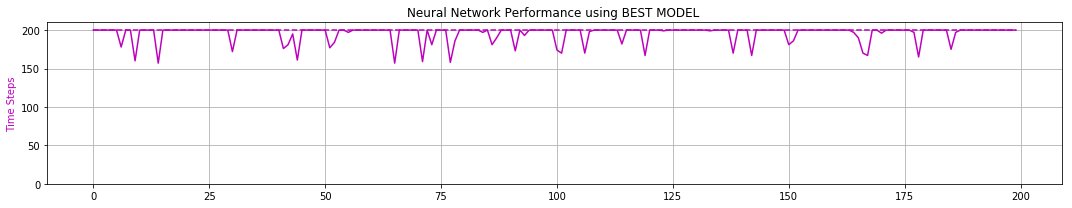

0 -max- [ 0.137  1.013  0.051  1.245  0.475]
0 -min- [-2.400 -2.044 -0.207 -1.458  0.425]

1 -max- [ 0.120  0.942  0.061  1.267  0.525]
1 -min- [-2.399 -2.183 -0.206 -1.678  0.475]

2 -max- [ 0.112  0.948  0.048  1.280  0.575]
2 -min- [-2.400 -2.205 -0.177 -1.556  0.526]

3 -max- [ 0.194  0.954  0.060  1.259  0.625]
3 -min- [-2.400 -2.264 -0.198 -1.575  0.576]

4 -max- [ 0.118  0.824  0.070  1.078  0.674]
4 -min- [-2.398 -2.225 -0.185 -1.319  0.625]

5 -max- [ 0.501  0.975  0.061  1.237  0.725]
5 -min- [-2.399 -2.267 -0.189 -1.588  0.675]

6 -max- [ 0.733  1.515  0.067  1.184  0.774]
6 -min- [-2.400 -2.251 -0.181 -1.857  0.725]

7 -max- [ 0.407  0.985  0.060  1.059  0.825]
7 -min- [-2.400 -2.419 -0.187 -1.482  0.775]

8 -max- [ 0.769  1.320  0.076  1.242  0.874]
8 -min- [-2.400 -2.449 -0.167 -1.623  0.826]

9 -max- [ 0.969  1.393  0.080  1.694  0.925]
9 -min- [-2.399 -2.447 -0.190 -1.573  0.877]



ITERATION # 29
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

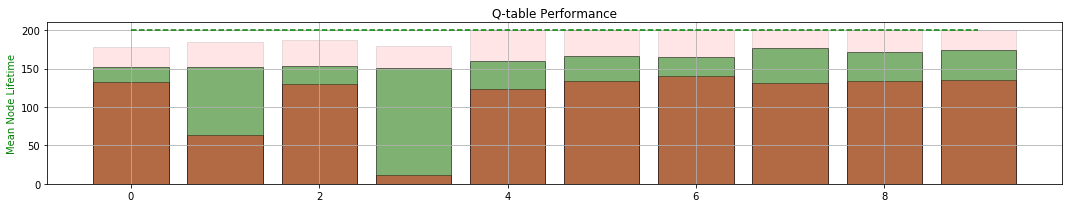

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  26192
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  183.275
Validating... MEAN TIME:  186.29
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:48.192926


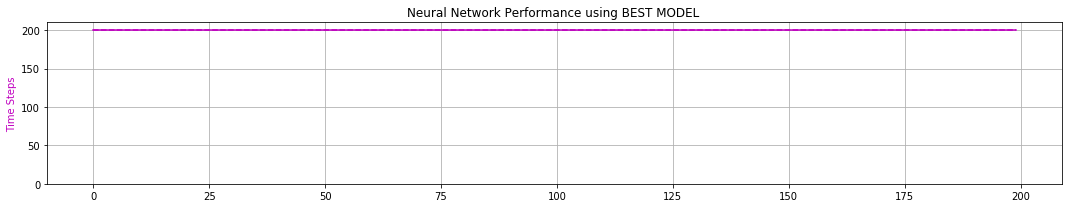

0 -max- [ 0.161  0.939  0.077  0.930  0.474]
0 -min- [-2.400 -2.087 -0.172 -1.357  0.426]

1 -max- [ 0.154  0.965  0.053  1.206  0.524]
1 -min- [-2.400 -2.189 -0.201 -1.422  0.476]

2 -max- [ 0.179  0.995  0.049  1.002  0.574]
2 -min- [-2.400 -2.060 -0.160 -1.446  0.526]

3 -max- [ 0.176  1.025  0.063  1.037  0.625]
3 -min- [-2.400 -2.060 -0.200 -1.502  0.575]

4 -max- [ 0.200  1.017  0.054  1.493  0.675]
4 -min- [-2.400 -2.239 -0.208 -1.491  0.625]

5 -max- [ 0.143  1.020  0.059  1.084  0.724]
5 -min- [-2.400 -2.246 -0.203 -1.439  0.675]

6 -max- [ 0.177  0.985  0.054  1.081  0.774]
6 -min- [-2.399 -2.210 -0.172 -1.434  0.725]

7 -max- [ 0.180  1.020  0.050  0.869  0.824]
7 -min- [-2.400 -2.247 -0.168 -1.450  0.776]

8 -max- [ 0.191  1.174  0.053  0.875  0.874]
8 -min- [-2.400 -2.382 -0.177 -1.672  0.825]

9 -max- [ 0.158  0.960  0.055  0.886  0.925]
9 -min- [-2.400 -2.402 -0.196 -1.468  0.875]



In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    if iteration < 3:
        node_EPSILON   = (iteration+1) * 0.2
    else:
        node_EPSILON   = T_EPSILON
    
    print("\n")
    print("ITERATION #", iteration)
    print("MEAN TABULAR EPSILON = ", node_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    start = timeit.default_timer()
    for node_id in range(NO_OF_NODES):
#         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
#         ###############################################
        [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
         C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
#         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
        node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
#         # CREATE STATE COMBINATIONS
#         ###############################################

#         node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN ],
#                                             [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX ],
#                                             [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################

#         # GET Q-VALUES 
#         %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#         # SAVE QFILE
#         node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#         np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
#     print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()
    

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  5024.0
Total Serial Timesteps   :  3752889.0
Speed-up                 :  746.99


In [21]:
pool.close()
pool.join()